In [1]:
from julia.api import Julia
# Disable the compiled module cache for compatibility. This leads to fairly long runtimes for this cell
jl = Julia(compiled_modules=False)
# Set the julia project to be the parent directory
from julia import Pkg
Pkg.activate("..")
# Load the EpidemciRL julia code
from julia import EpidemicRL as erl
from julia import Base

# Import some regular python packages
import numpy as np
import matplotlib.pyplot as plt
import time
# Make the default figure size a bit bigger
plt.rcParams["figure.figsize"] = [8, 6]

# LogitNormal Policy

We'll work with a parameterized policy that chooses actions as follows:

1. Use a feature extractor to convert the current SIRQState into a feature vector $\varphi$.
2. Compute $\mu = \varphi \cdot \theta$, where $\theta$ are the current policy parameters.
3. Output an action sampled from a Logit-normal distribution with parameters $\mu$ and $\sigma = 0.05$.

Since the Logit-normal distribution always outputs values in the interval $[0,1]$, we can think of these values as the fraction of infected individuals to quarantine. We will use the REINFORCE algorithm to find good a good value for the policy parameter vector $\theta$.

# Warmup: Constant Feature Extractor

First we'll try things out in a simple case where the feature extractor outputs $\varphi = [1.0]$ for every state. In this case, the parameter $\mu$ of the Logit-normal distribution is given by $\mu = \varphi \cdot \theta = 1 \cdot \theta = \theta$.
In this case the agent uses the same distribution for every state, and the policy's single parameter is exactly the $\mu$ parameter of the Logit-normal distribution.

Since we have a single parameter, we can plot the average return as a function of the policy parameter:

CPU times: user 26.4 s, sys: 59.6 ms, total: 26.5 s
Wall time: 26.4 s
Best mu = 0.2912912912912913, return = -1804.1407915828127


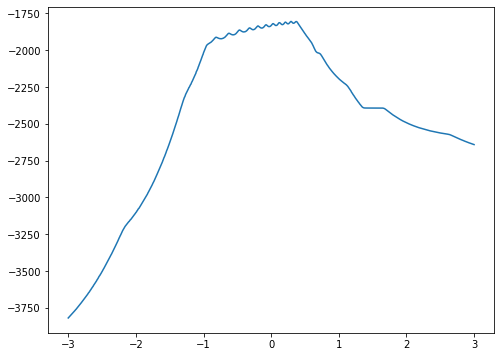

In [2]:
def evaluate_mu(env, mu):
    feature_extractor = erl.ConstantFeatureExtractor()
    policy = erl.LogitNormalPolicy(feature_extractor, 0.05)
    policy_parameters = np.array([mu])
    agt_f = erl.NonLearningAgent(policy, policy_parameters)
    agt_Q = erl.ActionTransformer(agt_f, erl.fraction_to_quarantines)
    avg_return = np.mean(erl.do_episodes(env, agt_Q, 1000))
    return avg_return

env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000), 1.4, 0.4)
mu_values = np.linspace(-3, 3, 1000)
%time avg_returns = [evaluate_mu(env, mu) for mu in mu_values]

# Find the best value of mu
best_mu_index = np.argmax(avg_returns)
best_mu = mu_values[best_mu_index]
print(f"Best mu = {best_mu}, return = {avg_returns[best_mu_index]}")

# Plot the average return as a function of mu
plt.plot(mu_values, avg_returns)

Now we'll use REINFORCE to try to optimize the single policy parameter. Since the learning process involves randomness, we'll run the algorithm a few times to see the variability.

Run 0:
  Final parameters = [-0.0215136]
  Most likely fraction quarantined = 0.49462180682667384
Run 1:
  Final parameters = [-0.05409485]
  Most likely fraction quarantined = 0.4864795850352926
Run 2:
  Final parameters = [-0.07282393]
  Most likely fraction quarantined = 0.48180205954761085


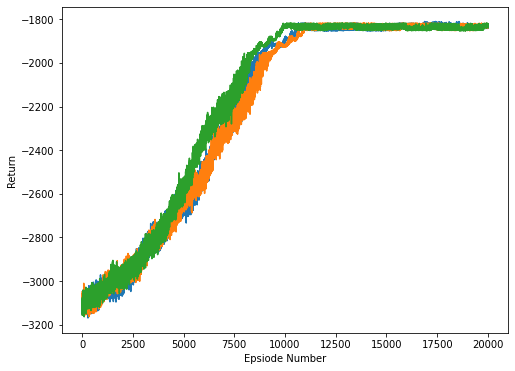

In [3]:
env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000, 0), 1.4, 0.4)

# --- Create the agent --- #

# Create a feature extractor that converts `SIRQState`s into feature vectors
feature_extractor = erl.ConstantFeatureExtractor()

# Create the policy that we'll use for learning
policy = erl.LogitNormalPolicy(feature_extractor, 0.05)

# Create initial policy parameters. In this case, all parameters are set to -2
policy_parameters = -2 * np.ones(erl.num_features(feature_extractor))

# Initialize the optimizer. The array we pass in is the initial value of the parameter mu
optimizer = erl.Adam(policy_parameters)

# Create the Reinforce agent. We pass in the state type, action t
agt_f = erl.ReinforceAgent(erl.SIRQState, Base.Float64, policy, optimizer)

# The actions output by `agt_f` are fractions, but the environment expects a count of the
# number of quarantines to use. We can use an `ActionTransformer` to convert those fractions
# into quarantine counts using.
agt_Q = erl.ActionTransformer(agt_f, erl.fraction_to_quarantines)

# --- Run Episodes and Plot Results --- #

plt.plot()

for i in range(3):
    agt = erl.copy(agt_Q)
    returns = erl.do_episodes(env, agt, 20000)
    final_params = erl.get_params(agt.agt.opt)
    print(f"Run {i}:")
    print(f"  Final parameters = {final_params}")
    print(f"  Most likely fraction quarantined = {erl.logistic(final_params[0])}")
    plt.plot(returns)
    plt.xlabel("Epsiode Number")
    plt.ylabel("Return")

In all three runs, we see that the agent learns to quarantine slightly less than half of the infected individuals each day, and that after around 12500 episodes their returns seem to level off at about -1800, which is close to the optimal value we found of -1804.25.

# Tile Coding Feature Extractor

Next we'll run an almost identical experiment, except we'll use a more interesting feature extractor. This feature extractor will divide the space of $(S,I,R,Q,max_I)$ values into a regular grid and allow the agent to change the fraction they quarantine in each grid cell. We can specify the number of bins to use for each of the 5 dimensions.

We'll start with exploring how the tile coder works when we only divide the space along the "S" count.

In [4]:
S_bins = 5
I_bins = 1
R_bins = 1
Q_bins = 1
max_I_bins = 1
feature_extractor = erl.SIRQTileCoder(S_bins, I_bins, R_bins, Q_bins, max_I_bins)

def print_features(N, S):
    state = erl.SIRQState(S, N-S, 0, 0, 0)
    print(f"feature vector when S = {S:4d}: {erl.get_features(feature_extractor, state)}")

print_features(1000, 0)
print_features(1000, 199)
print_features(1000, 200)
print_features(1000, 399)
print_features(1000, 400)
print_features(1000, 599)
print_features(1000, 600)
print_features(1000, 799)
print_features(1000, 800)
print_features(1000, 1000)

feature vector when S =    0: [1.0, 0.0, 0.0, 0.0, 0.0]
feature vector when S =  199: [1.0, 0.0, 0.0, 0.0, 0.0]
feature vector when S =  200: [0.0, 1.0, 0.0, 0.0, 0.0]
feature vector when S =  399: [0.0, 1.0, 0.0, 0.0, 0.0]
feature vector when S =  400: [0.0, 0.0, 1.0, 0.0, 0.0]
feature vector when S =  599: [0.0, 0.0, 1.0, 0.0, 0.0]
feature vector when S =  600: [0.0, 0.0, 0.0, 1.0, 0.0]
feature vector when S =  799: [0.0, 0.0, 0.0, 1.0, 0.0]
feature vector when S =  800: [0.0, 0.0, 0.0, 0.0, 1.0]
feature vector when S = 1000: [0.0, 0.0, 0.0, 0.0, 1.0]


Next, we can run REINFORCE with this feature extractor the same way as before.

Run 0:
  Final parameters = [-2.         -2.26021711 -0.27174133 -0.07480577 -0.04913396]
Run 1:
  Final parameters = [-2.         -3.25479546 -1.41362474 -0.07857845 -0.07572243]
Run 2:
  Final parameters = [-2.         -2.99903882 -1.25132827 -0.0880569  -0.10652144]


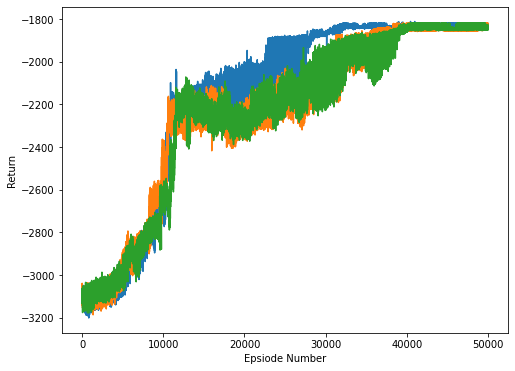

In [5]:
env = erl.SIRQEnvironment(erl.SIRQState(9999, 1, 0, 2000, 0), 1.4, 0.4)

# --- Create the agent --- #

# Create a feature extractor that converts `SIRQState`s into feature vectors
S_bins = 5
I_bins = 1
R_bins = 1
Q_bins = 1
max_I_bins = 1
feature_extractor = erl.SIRQTileCoder(S_bins, I_bins, R_bins, Q_bins, max_I_bins)

# Create the policy that we'll use for learning
policy = erl.LogitNormalPolicy(feature_extractor, 0.05)

# Create initial policy parameters. In this case, all parameters are set to -2
policy_parameters = -2 * np.ones(erl.num_features(feature_extractor))

# Initialize the optimizer. The array we pass in is the initial value of the parameter mu
optimizer = erl.Adam(policy_parameters)

# Create the Reinforce agent. We pass in the state type, action t
agt_f = erl.ReinforceAgent(erl.SIRQState, Base.Float64, policy, optimizer)

# The actions output by `agt_f` are fractions, but the environment expects a count of the
# number of quarantines to use. We can use an `ActionTransformer` to convert those fractions
# into quarantine counts using.
agt_Q = erl.ActionTransformer(agt_f, erl.fraction_to_quarantines)

# --- Run Episodes and Plot Results --- #

plt.plot()

for i in range(3):
    agt = erl.copy(agt_Q)
    returns = erl.do_episodes(env, agt, 50000)
    final_params = erl.get_params(agt.agt.opt)
    print(f"Run {i}:")
    print(f"  Final parameters = {final_params}")
    plt.plot(returns)
    plt.xlabel("Epsiode Number")
    plt.ylabel("Return")